# ООН Женщины. Анализ 

## Анализ выборочного обследования по насилию в отношении женщин. Казахстан

Здесь мои расчёты для [статьи](https://medium.com/@bjolko/%D1%87%D0%B5%D0%BC-%D0%BD%D0%B5%D0%B4%D0%BE%D0%B2%D0%BE%D0%BB%D1%8C%D0%BD%D1%8B-%D1%84%D0%B5%D0%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D0%BA%D0%B8-%D0%B2-%D0%BA%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%D0%B5-%D1%87%D0%B0%D1%81%D1%82%D1%8C-1-490a521d2f7).

**Содержание**
1. Импорт данных из .docx формата
2. Предобработка
3. Графики

## Настройки и подгрузка библиотек

In [1]:
options(warn = -1, repr.plot.height = 6, repr.plot.width = 9)

In [16]:
library(dplyr)
library(stringr)
library(docxtractr)
library(tibble)
library(ggplot2)
library(openxlsx)

## Импорт данных

Исследование в pdf формате, но он плохо считался. Поэтому через MS Word я конвертировала pdf в docx и работала уже с ним. Из-за конвертации много таблиц слетело, пришлось делать много ручной предобработки. 

In [3]:
# Словари для названий колонок и строк с описанием данных

regions <- c('Акмолинская','Актюбинская','Алматинская','Атырауская','ЗКО','Жамбылская',
             'Карагандинская','Костанайская','Кызылординская','Мангистауская','ЮКО',
             'Павлодарская','СКО','ВКО','г. Астана','г. Алматы')

cols_abuse_type <- c('abuse_type', 'cnt', 'share', 'ci_95', 'country_share')

cols_abuse_dem <- c('dem_group', 'all_cnt', 'all_share', 'now_cnt', 'now_share', 'country_share')

cols_control <- c('control_type', 'all_cnt', 'all_share', 'now_cnt', 'now_share', 'nothing', 'country_share')

cols_other <- c('abuse_type', 'cnt', 'share', 'country_share')

rows_abuse_type <- c('Физическое насилие',
                     'В течение жизни',
                     'В настоящее время (последние 12 месяцев)',
                     'Сексуальное насилие',
                     'В течение жизни',
                     'В настоящее время (последние 12 месяцев)',
                     'Физическое и/или сексуальное насилие**',
                     'В течение жизни',
                     'В настоящее время (последние 12 месяцев)',
                     'Психологическое насилие',
                     'В течение жизни',
                     'В настоящее время (последние 12 месяцев)',
                     'Экономическое насилие',
                     'В течение жизни',
                     'В настоящее время (последние 12 месяцев)',
                     'Всего женщин, имевших когда-либо партнера')

rows_abuse_dem <- c('Возрастная группа',
                    '18-24 лет',
                    '25-29 лет',
                    '30-39 лет',
                    '40-49 лет',
                    '50-59 лет',
                    '60-75 лет',
                    'Тип местности',
                    'Город',
                    'Село',
                    'Образование',
                    'Начальное/неполное среднее',
                    'Среднее',
                    'Техническое/профессиональное',
                    'Высшее/аспирантура',
                    'Размер домохозяйства ',
                    '1 человек',
                    '2-3 человека',
                    '4-5 человек',
                    '6+ человек',
                    'Статус экономической активности ',
                    'Не работает',
                    'Работает',
                    'Среднемесячный доход домохозяйства (в тенге) ',
                    'До 40 000',
                    '40 000 - 60 000',
                    '60 001 - 100 000',
                    '100 001 - 140 000',
                    '140 001 - 200 000',
                    'Свыше 200 000',
                    'Среднемесячный доход на душу населения по квинтильным группам (в тенге)',
                    'До 15 999',
                    '16 000 - 24 999',
                    '25 000 - 39 999',
                    '40 000 - 49 999',
                    'Свыше 50 000')

rows_control <- c('Не разрешает видеться с друзьями',
                  'Ограничивает общение с семьей',
                  'Настаивает на том, чтобы знать о ее местонахождении',
                  'Игнорирует и относится с равнодушием',
                  'Злится, если заговорит с посторонними мужчинами',
                  'Подозревает в неверности',
                  'Ожидает, что будет отпрашиваться у него в больницу',
                  'Навязывает религиозные убеждения',
                  'Хотя бы 1 из вышеуказанного',
                  'Хотя бы 3 из вышеуказанного',
                  'Всего женщин, имевших когда-либо партнеров')

rows_other <- c('Экономическое',
                'Психологическое',
                'Физическое',
                'Изнасилование',
                'Попытка изнасилования или иное сексуальное насилие',
                'Любое сексуальное насилие',
                'Всего женщин')

In [4]:
# Импорт данных из docx

location_2 <- 'ООН Женщины. Насилие в отношении женщин-Приложение.docx'

doc <- read_docx(location_2)

all_tables <- docx_tbl_count(doc)

In [5]:
find_tables <- function(keyword, vector_name = c()) {
    
    ### Поиск номеров таблиц в файле doc по названию заголовка таблицы
    
    for (i in 20:all_tables) {
        if (str_detect(colnames(docx_extract_tbl(doc, i))[1], keyword)) {
            vector_name <- c(vector_name, i)
        }
        i = i + 1
    }
    vector_name
}

In [6]:
# Номера таблиц с информацией о типах испытанного насилия

abuse_type_i <- find_tables('аспространенность.насилия')

abuse_type_1 <- abuse_type_i[c(TRUE, FALSE)] # Насилие со стороны партнера

abuse_type_2 <- abuse_type_i[c(FALSE, TRUE)] # Насилие со стороны других людей

# Соц-демографические данные опрашиваемых

abuse_dem_i <- find_tables('Насилие.со.стороны.') 

# Статистика по типам контролирующего поведения

abuse_control_i <- find_tables('Контролирующее.поведение.') 

In [7]:
make_empty_df  <- function(columns) {
    
    ### Создание пустых датафреймов с названными колонками
    
    read.csv(text = paste0('region, ', columns, 'metric, value'), stringsAsFactors = F)
}

In [8]:
# Пустые датафреймы для заполнения

df_abuse_type <- make_empty_df('question, abuse_type, ')

df_abuse_dem <- make_empty_df('question, dem_group, ')

df_abuse_control <- make_empty_df('control_type')

df_abuse_other <- make_empty_df('control_type')

In [9]:
# Заполнение таблиц

i <- 0

for (region_name in regions) {
  
  i = i + 1
  
  #print(region_name)
  
  #print('Типы насилия со стороны интимного партнера')
  
  tmp <- # Заполнение df_abuse_type, насилие со стороны интимного партнёра
      docx_extract_tbl(doc, abuse_type_1[i]) %>% 
      setNames(cols_abuse_type) %>% 
      tail(length(rows_abuse_type)) %>% 
      na_if('') %>% 
      mutate(abuse_type = rows_abuse_type,
             question = ifelse(is.na(cnt), abuse_type, NA)) %>% 
      tidyr::fill(question) %>% 
      select(question, everything()) %>% 
      filter(!is.na(cnt), !str_detect(abuse_type,'Всего женщин')) %>% 
      select(-ci_95) %>% 
      tidyr::gather('metric', 'value', -question, -abuse_type) %>% 
      mutate(value = as.numeric(str_replace(value, ',', '.')),
             region = region_name) %>% 
      select(region, everything())
    
    df_abuse_type <- rbind(df_abuse_type, tmp)
  
  #print('Насилие по соц-дем')
  
  # Заполнение df_abuse_dem, соц-дем характеристики
  # Модифицируем rows_abuse_dem для Астаны и Алматы, где нет разделения на город / село
  if (i %in% 15:16) {
    rows_abuse_dem_tmp <- rows_abuse_dem[!str_detect(rows_abuse_dem, 'Тип местности|Город|Село')]
  } else {
    rows_abuse_dem_tmp <- rows_abuse_dem
  }
  
  tmp <- 
    docx_extract_tbl(doc, abuse_dem_i[i]) %>% 
    setNames(cols_abuse_dem) %>% 
    tail(ifelse(i %in% c(15,16), length(rows_abuse_dem)-3, length(rows_abuse_dem))) %>% 
    na_if('') %>% 
    mutate(dem_group = rows_abuse_dem_tmp,
           question = ifelse(is.na(all_cnt), dem_group, NA)) %>% 
    tidyr::fill(question) %>% 
    select(question, everything()) %>% 
    filter(!is.na(all_cnt), !str_detect(dem_group,'Всего женщин')) %>% 
    tidyr::gather('metric', 'value', -question, -dem_group) %>% 
    mutate(value = as.numeric(str_replace(value, ',', '.')),
           region = region_name) %>% 
    select(region, everything())
    
    df_abuse_dem <- rbind(df_abuse_dem, tmp)
    
  #print('Контролирующее поведение')
    
  # Заполнение df_abuse_control, контролирующее поведение
  # Модифицируем cols_control, в некоторых таблицах подгрузились пустые колонки
    if (ncol(docx_extract_tbl(doc, abuse_control_i[i])) == length(cols_control)) {
    cols_control_tmp <- cols_control
  } else {
    cols_control_tmp <- cols_control[!str_detect(cols_control, 'nothing')]
  }
  
  tmp <- 
    docx_extract_tbl(doc, abuse_control_i[i]) %>% 
    setNames(cols_control_tmp) %>% 
    tail(length(rows_control)) %>% 
    na_if('') %>% 
    mutate(control_type = rows_control) %>%
    select(-matches('nothing')) %>% 
    filter(!str_detect(control_type,'Всего женщин')) %>% 
    tidyr::gather('metric', 'value', -control_type) %>% 
    mutate(value = as.numeric(str_replace(value, ',', '.')),
           region = region_name) %>% 
    select(region, everything())
  
  df_abuse_control <- rbind(df_abuse_control, tmp)
  
  #print('Насилие со стороны других людей')
    
  # Заполнение df_abuse_other, насилие со стороны других людей
  # Модифицируем cols_other, в некоторых таблицах подгрузились пустые колонки
    
  if (ncol(docx_extract_tbl(doc, abuse_type_2[i])) == length(cols_other)) {
    cols_other_tmp <- cols_other
  } else {
    cols_other_tmp <- c(cols_other[1:2], 'nothing', cols_other[3:4])
  }
  
  tmp <- 
    docx_extract_tbl(doc, abuse_type_2[i]) %>% 
    setNames(cols_other_tmp) %>% 
    select(-matches('nothing')) %>% 
    tail(length(rows_other)) %>% 
    na_if('') %>% 
    mutate(abuse_type = rows_other) %>% 
    filter(!str_detect(abuse_type,'Всего женщин')) %>% 
    tidyr::gather('metric', 'value', -abuse_type) %>% 
    mutate(value = as.numeric(str_replace(value, ',', '.')),
           region = region_name) %>% 
    select(region, everything())
  
  df_abuse_other <- rbind(df_abuse_other, tmp)
    
}


In [10]:
# Количество опрошенных по регионам

total_cnt <- function(df_num) {
    
  ### Считаем данные по количеству опрошенных и тех, у кого был партнер
    
  docx_extract_tbl(doc, df_num, header = F) %>% 
    select(1) %>% 
    slice(3) %>% 
    pull(V1) %>% 
    str_split("\\)", simplify = T) %>% 
    gsub('[^[:digit:]]', '', .) %>% 
    as.numeric() %>% 
    .[1:length(regions)]
}

total_cnt_regions <- data.frame(region = regions,
                                had_partner = total_cnt(14),
                                all_women = total_cnt(16),
                                stringsAsFactors = F)

total_cnt_regions

NOTE: header=FALSE but table has a marked header row in the Word document
NOTE: header=FALSE but table has a marked header row in the Word document


region,had_partner,all_women
<chr>,<dbl>,<dbl>
Акмолинская,802,913
Актюбинская,829,926
Алматинская,775,873
Атырауская,781,928
ЗКО,867,939
Жамбылская,809,916
Карагандинская,793,895
Костанайская,881,914
Кызылординская,772,879


## Анализ

In [11]:
# Готовим таблицу для EDA, убираем оценочные метрики на душу населения
eda_dem <- 
  df_abuse_dem %>% 
  filter(metric == 'now_share', !str_detect(question, 'на душу'))

# Уникальные значения групп населения
dem_groups <- 
  eda_dem %>% 
  filter(region == 'Акмолинская') %>% 
  pull(dem_group)

# Сокращенные названия групп для визуализации
dg_labels <-
  str_replace(dem_groups, ' лет', '') %>% 
  str_replace_all(., 'человека|человек', '') %>% 
  str_replace_all(., ' 000| 001', '') %>% 
  str_replace_all(., '/', '/\n')

eda_dem$dg_factor <- factor(eda_dem$dem_group, levels = dem_groups, labels = dg_labels)

In [12]:
# Тема для графиков
viz_theme  <- 
    theme(axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank(),
        panel.background = element_rect(fill = '#FFFCED', colour = NA),
        panel.grid.major.y = element_line(size = 0.5, linetype = 'dotted',
                                        colour = '#E4DAA1'),
        panel.grid.major.x = element_blank(),
        panel.grid.minor = element_blank(),
        strip.background = element_rect(color = NA, fill = '#FFFCED'),
        strip.text = element_text(hjust = 0.030, size = 12, face = 'bold'),
        plot.title = element_text(face = "bold", size = 20, margin = margin(b = 10), hjust = 0.030),
        plot.subtitle = element_text(face = "italic", size = 10, margin = margin(b = 10), hjust = 0.020),
        plot.caption = element_text(size = 8),
        plot.background = element_rect(fill = '#FFFCED'))

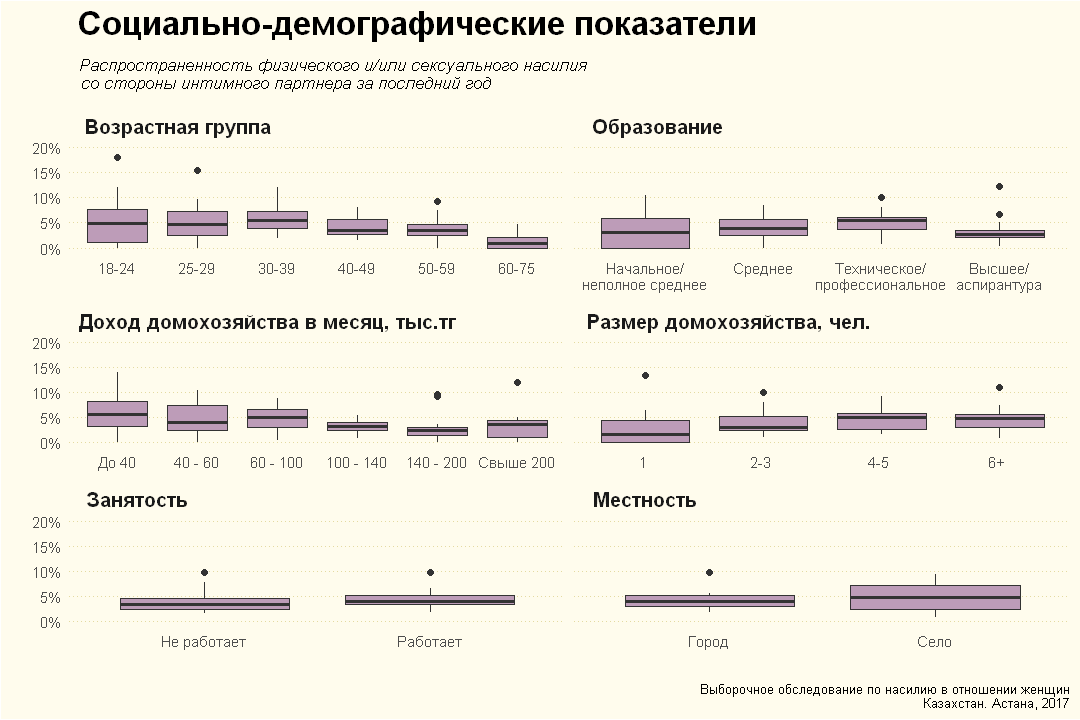

In [13]:
# Соц-дем распределение
eda_dem %>% 
  mutate(question = recode(str_trim(question),
                           'Среднемесячный доход домохозяйства (в тенге)' = 'Доход домохозяйства в месяц, тыс.тг',
                           'Размер домохозяйства' = 'Размер домохозяйства, чел.',
                           'Статус экономической активности' = 'Занятость',
                           'Тип местности' = 'Местность',
                           .default = str_trim(question)),
         question = ordered(question, levels = c('Возрастная группа', 'Образование',
                                                 'Доход домохозяйства в месяц, тыс.тг',
                                                 'Размер домохозяйства, чел.',
                                                 'Доход домохозяйства\nв месяц, тыс.тг',
                                                 'Занятость',
                                                 'Местность')),
         value = value / 100) %>% 
  ggplot(aes(x = dg_factor, y = value)) +
  geom_boxplot(fill = '#BD9CB8') +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1), limits = c(0, .2)) +
  facet_wrap(.~question, ncol = 2, scale = 'free_x') +
  labs(x = '', y = '', title = 'Социально-демографические показатели',
       caption = 'Выборочное обследование по насилию в отношении женщин\nКазахстан. Астана, 2017',
       subtitle = 'Распространенность физического и/или сексуального насилия\nсо стороны интимного партнера за последний год') +
  viz_theme

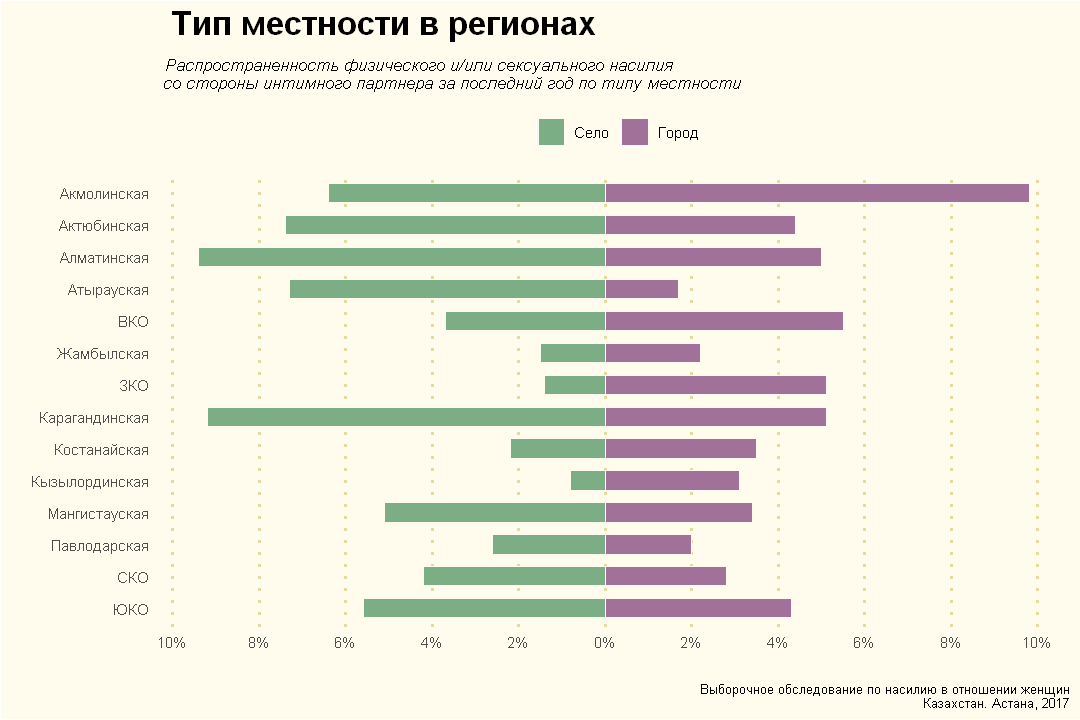

In [14]:
# Сравнение город-село
eda_dem %>% 
  mutate(value = value/100,
         tooltip = paste0('Область: ', region, '\nМестность: ', dem_group, '\nДоля: ', scales::percent(value, 1))) %>% 
  filter(question == 'Тип местности') %>%
  mutate(value = ifelse(dem_group == 'Город', value, -value),
         region = forcats::fct_rev(region)) %>% 
  ggplot(aes(x = region, y = value, fill = dem_group, text = tooltip)) +   # Fill column
  geom_bar(stat = "identity", width = .6, col = '#FFFCED') +  
  scale_y_continuous(breaks =  seq(-0.4, 0.4, 0.02),
                     labels = scales::percent(c(seq(0.4, 0, -0.02), seq(0.02, 0.4, 0.02)), 2)) +
  scale_fill_manual(values = c('#A17199', '#7BAE84')) +
  coord_flip() +
  labs(y = '', x = '', fill = '', title = 'Тип местности в регионах',
       caption = 'Выборочное обследование по насилию в отношении женщин\nКазахстан. Астана, 2017',
       subtitle = 'Распространенность физического и/или сексуального насилия\nсо стороны интимного партнера за последний год по типу местности') +
  guides(fill = guide_legend(reverse = TRUE)) +
  theme(legend.position = 'top') +
  viz_theme +
  theme(legend.background = element_rect(fill = 'transparent'),
        panel.grid.major.x = element_line(size = 1, linetype = 'dotted', colour = '#E4DAA1'),
        panel.grid.major.y = element_blank())

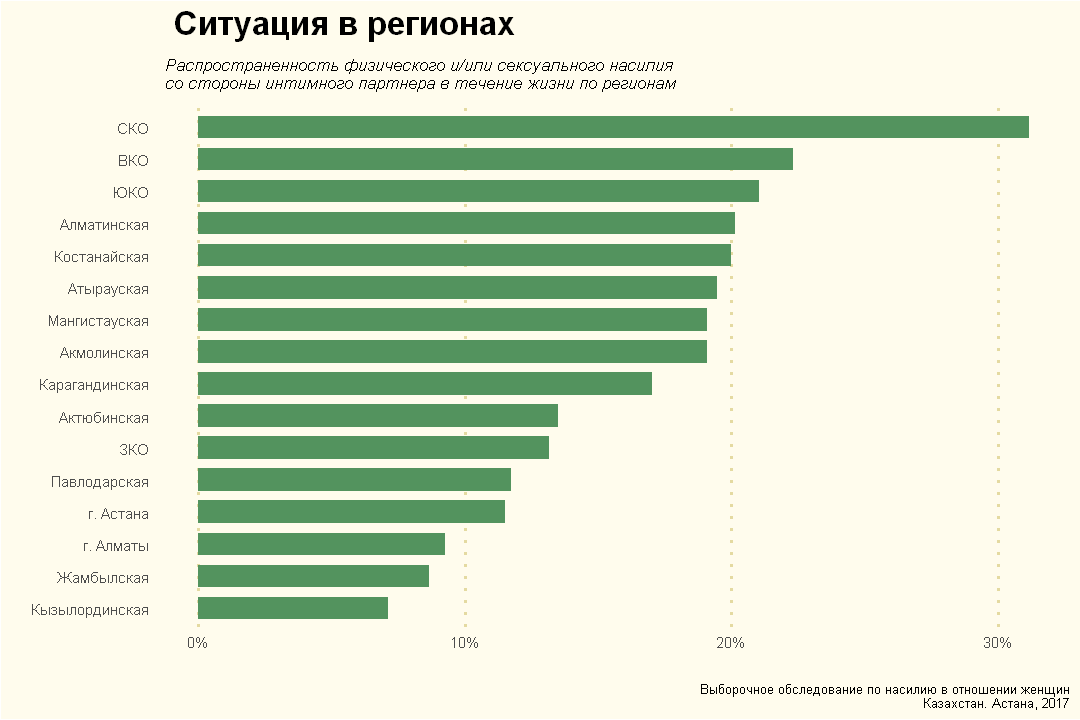

In [15]:
# Сравнение регионов
regions_comparison <- 
  df_abuse_dem %>% 
  filter(question == 'Возрастная группа', metric == 'all_cnt') %>% 
  group_by(region) %>% 
  summarise(abused = sum(value)) %>% 
  left_join(total_cnt_regions, by = 'region') %>% 
  mutate(abused_share = abused/had_partner) %>% 
  tidyr::gather(metric, value, -region)
  
regions_comparison %>% 
  filter(metric == 'abused_share') %>% 
  ggplot(aes(x = forcats::fct_reorder(region, value), y = value)) +
  geom_bar(stat = 'identity', fill = '#53935E', width = .7) +
  labs(x = '', y = '', title = 'Ситуация в регионах',
       caption = 'Выборочное обследование по насилию в отношении женщин\nКазахстан. Астана, 2017',
       subtitle = 'Распространенность физического и/или сексуального насилия\nсо стороны интимного партнера в течение жизни по регионам') +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  coord_flip() +
  viz_theme +
  theme(panel.grid.major.x = element_line(size = 1, linetype = 'dotted', colour = '#E4DAA1'),
        panel.grid.major.y = element_blank())